<a href="https://colab.research.google.com/github/ujs/cifar10/blob/master/cifarNEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dataujs","key":"4070effe6d105acff94a4a8b4d44777f"}'}

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
unanimad/dataisbeautiful                                    Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28            717  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          27407  
rubenssjr/brasilian-houses-to-rent                          brazilian_houses_to_rent                            117KB  2020-03-15 01:12:22            697  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     412KB  2020-03-24 06:10:13          76577  
kimjihoo/coronavirusdataset                                 Data

In [6]:
!kaggle competitions download -c cifar-10

 93% 97.0M/105M [00:03<00:00, 12.3MB/s]
100% 105M/105M [00:03<00:00, 30.3MB/s] 
  0% 0.00/575k [00:00<?, ?B/s]
100% 575k/575k [00:00<00:00, 81.5MB/s]
  0% 0.00/655k [00:00<?, ?B/s]
100% 655k/655k [00:00<00:00, 43.2MB/s]
 99% 606M/610M [00:15<00:00, 28.8MB/s]
100% 610M/610M [00:15<00:00, 42.0MB/s]


In [7]:
!ls

kaggle.json  sampleSubmission.csv.zip  train.7z
sample_data  test.7z		       trainLabels.csv


In [8]:



!7z e train.7z



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 109723070 bytes (105 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 109723070
Headers Size = 294768
Method = LZMA:26
Solid = +
Blocks = 1

  0%      2%      2% 614 - train/10550.png                            2% 987 - train/10887.png                            2% 1267 - train/11138.png                             2% 1493 - train/11341.png                             2% 1687 - train/11516.png                           

In [9]:
#importing libraries and performing EDA
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
import keras
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import layers
from keras import backend
from keras import Input
from keras.preprocessing import image
original_train_set = '/content/'
original_train_labels = 'trainLabels.csv'

#reading labels csv into python and parsing
f = open(original_train_labels)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
lines[1].split(',')
cols = []
for i in range (len(lines)):
    cols.append(lines[i].split(','))
    

print(header)

#extracting only the labels into a list
labels = [cols[i][1] for i in range(len(cols)-1)]

Using TensorFlow backend.


['id', 'label']


   id       label
1   1        frog
2   2       truck
3   3       truck
4   4        deer
5   5  automobile
          id       label
49996  49996        bird
49997  49997        frog
49998  49998       truck
49999  49999  automobile
50000  50000  automobile


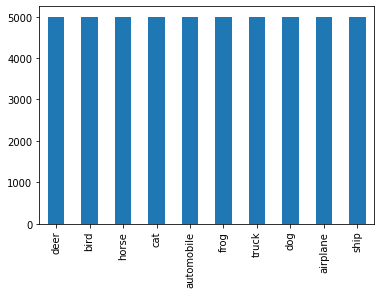

In [10]:
#converting data in dataframe
s1 = pd.Series(range(1,len(lines)), index = range(1,len(lines)), name = 'id')
s2 = pd.Series(labels,index = range(1,len(lines)), name = 'label')

df_labels = pd.concat([s1, s2], axis=1)
print(df_labels.head())
print(df_labels.tail())
unique_labels = df_labels.label.unique()
df_labels.label.value_counts() #this shows a uniform distribution of image classes
df_labels.label.value_counts().plot(kind ='bar')


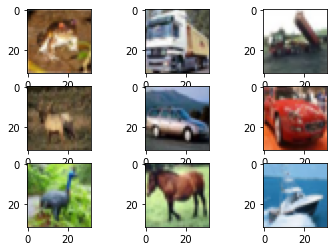

In [11]:

#More Visualization- seeing first 9 images in the training dataset
import matplotlib.image as mpimg 
for i in range(1,10):
    plt.subplot(330 + 0 + i)
    #define filename
    filename = str(i) + '.png'
    #load image pixels
    image = mpimg.imread(filename)
    #plot the data
    plt.imshow(image)
plt.show()


In [12]:
# Another way to convert csv to data frame
from pandas import read_csv

filename = 'trainLabels.csv'
map_csv = pd.read_csv(filename)
map_csv.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [13]:
map_csv.label.iloc[0]

'frog'

In [14]:
# Map categorical labels to integer using dictionaries

def create_label_map(map_csv):
  '''Function to map class labels to integers and vice versa'''
  #extracting set of unique labels, converting to sorted list. In this case there are 10 unique labels
  labels = list(map_csv.label.unique())
  labels.sort()
  #forward map
  labels_map = {labels[i]:i for i in range(len(labels))}
  #Inverse map
  inv_labels_map = {i:labels[i] for i in range(len(labels))}
  return labels_map, inv_labels_map

# Map all image file names to labels. Hash tables will taking constant time for retrieval
def create_file_map(map_csv):
  mapping = dict()

  for i in range(len(map_csv)):
    name, label = map_csv.id.iloc[i], map_csv.label.iloc[i]
    mapping[name] = label
  return mapping

#calling the funciton
label_dict = create_file_map(map_csv)
label_dict[10]





'cat'

In [15]:
#Let's call the above function
mapping, inv_mapping = create_label_map(map_csv)
print(len(mapping))
print(inv_mapping)
  


10
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [16]:
#One hot encoding representation of image label
def one_hot_encode(label, mapping):
  '''First input is label of the given image. Second input is label to integer map dictionary. Output is one hot encoded representation for the image label '''
  encoding = np.zeros(len(mapping), dtype = 'uint8')
  encoding[mapping[label]] = 1
  return encoding
  
#test the function
one_hot_encode('cat', mapping)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [17]:
# exploring os.walk funciton
for pth, dirs, files in os.walk('/content/'):
  print ('path: ', pth)
  print('dir: ', dirs)

path:  /content/
dir:  ['.config', 'train', 'sample_data']
path:  /content/.config
dir:  ['configurations', 'logs']
path:  /content/.config/configurations
dir:  []
path:  /content/.config/logs
dir:  ['2020.03.18']
path:  /content/.config/logs/2020.03.18
dir:  []
path:  /content/train
dir:  []
path:  /content/sample_data
dir:  []


In [0]:
# load all images into memory
def load_dataset(folder, label_dict, mapping):
  photos, targets = list(), list()
  # enumerate files in the directory
  filenames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f)) and f[-3:] == 'png']
  for filename in filenames[:10000]:
    # load image
    photo = keras.preprocessing.image.load_img(filename, target_size=(32,32))
    # convert to numpy array
    photo = keras.preprocessing.image.img_to_array(photo, dtype='uint8')
    # get labels for each image
    label_num = int(filename.split('.')[0])
    label = label_dict[label_num]
    # one hot encoded represenation of label
    target = one_hot_encode(label, mapping)
    # store
    photos.append(photo)
    targets.append(target)
  X = np.asarray(photos, dtype='uint8')
  y = np.asarray(targets, dtype='uint8')
  return X, y

#testing function
folder = '/content/'
result = load_dataset(folder, label_dict, mapping)

In [0]:
#Saving X,y in a compressed file
np.savez_compressed('cifar.npz',result[0],result[1])


# load prepared planet dataset
from numpy import load
data = load('cifar.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

In [0]:
# Defining Baseline Model Architechture
def define_model(input_shape = (32,32,3), output_shape = 10):
  input_tensor = Input(shape = input_shape)
  x = layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same')(input_tensor)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
  output_tensor = layers.Dense(output_shape, activation='sigmoid')(x)
  model = Model(input_tensor, output_tensor)

  # compilation
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#test function
model_baseline = define_model(input_shape = (32,32,3), output_shape = 10)
model_baseline.summary()


In [0]:
#Split data into train, validation, and test set
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, valX, trainY, valY = train_test_split(X, y, test_size=0.25, random_state=1)

#using ImageDataGenerator for random sampling and data normalization, augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(trainX,trainY, batch_size = 128)
val_generator = train_datagen.flow(valX,valY, batch_size = 128)

In [0]:
history = model_baseline.fit_generator(train_generator, steps_per_epoch = 1000, epochs = 10, validation_data = val_generator, validation_steps = 500)
model_baseline.save('cifar10_baseline')
history.history